In [1]:
# Imports
import tensorflow as tf
import glob
import os
import matplotlib.pyplot as plt


# Set to TF to GPU
devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(devices[0], True)

In [2]:
#Set up directories for dataset (These were retrived from D: in the GPU lab)

# Test
test_directory = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_test\*.png"))
seg_test_directory = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_test\*.png"))

# Train
train_directory = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_train\*.png"))
seg_train_directory = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_train\*.png"))

# Validation
validation_directory = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_validate\*.png"))
seg_validation_directory = sorted(glob.glob("D:\keras_png_slices_data\keras_png_slices_seg_validate\*.png"))

In [3]:
# Creates datasets, slice tensors, shuffle them.

# Test
test_data = tf.data.Dataset.from_tensor_slices(test_directory)
test_data = test_data.shuffle(len(test_directory))

# Train
train_data = tf.data.Dataset.from_tensor_slices(train_directory)
train_data = test_data.shuffle(len(train_directory))

# Validation
validation_data = tf.data.Dataset.from_tensor_slices(validation_directory)
validation_data = test_data.shuffle(len(validation_directory))                                               
           

In [4]:
# Pre processing and image displaying functions

# Map function

def pre_processing(input):
    
    # Read/output contents of filename
    data = tf.io.read_file(input)
    
    # Convert images to grayscale
    data = tf.image.decode_png(data, channels = 1)
    
    # Resize to 256*256
    data = tf.image.resize(data, (256,256))
    
    # Normalise to (-1,1)
    data = tf.cast(data, tf.float32)
    data = (data - 127.5)/127.5

    return data

# Function to map datasets and set batch sizes

def map_and_batch(input, map_func, batch_size):
    
    input = input.map(map_func).batch(batch_size)
    
    return input


# Functions to display images


# Process single

def show_image(input):
    
    # Configure output figure's dpi and size
    output = plt.figure(dpi = 600, figsize = (8,8))
    
    # Iterate over input to display
    input_range = range(len(input))
    for i in input_range:
        plt.subplot(3,3, i + 1)
        for j in range(9):
            plt.axis("off")
            plt.imshow(input[i], cmap = "gray")
            
    plt.show()
    

# Process multiple

def show_images(input):
    
    # Iterate over a batch of images
    for image in input:
        show_image([tf.squeeze(image)][0])

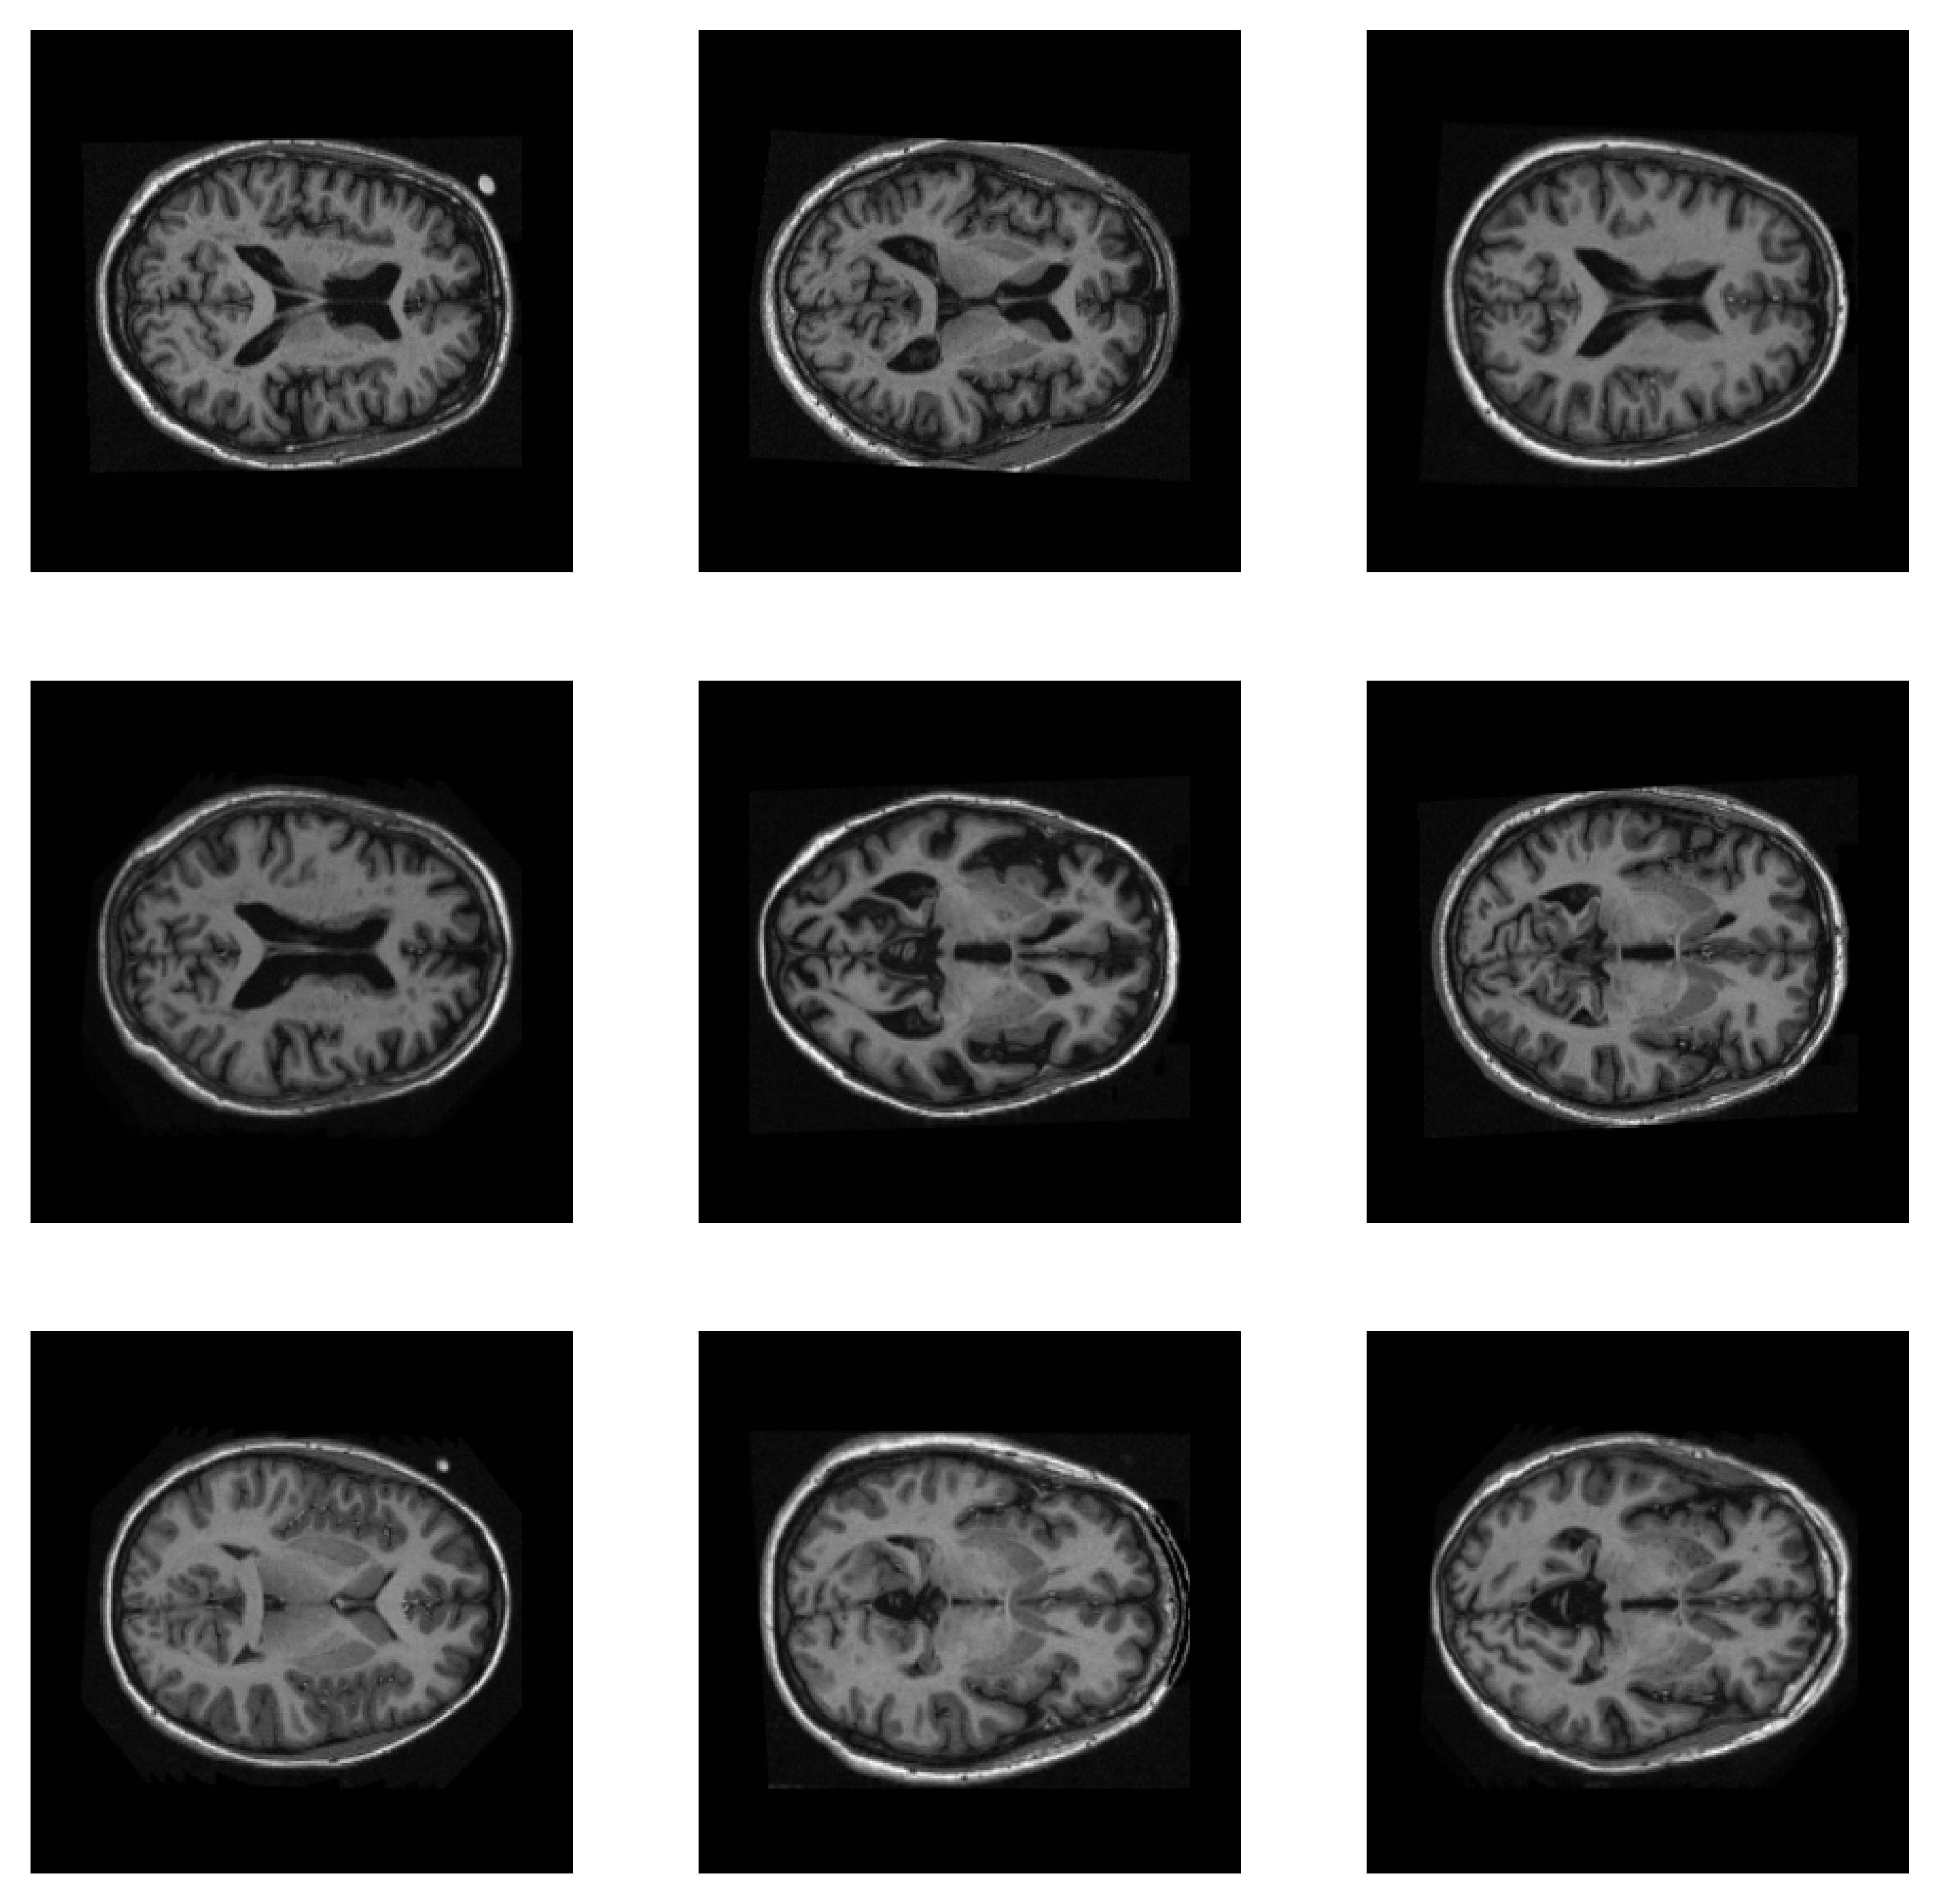

In [5]:
# Apply pre-processing functions to the data

test_data = map_and_batch(test_data, pre_processing, 9)
train_data = map_and_batch(train_data, pre_processing, 9)
validation_data = map_and_batch(validation_data, pre_processing, 9)


# Display one batch after processing to see 
# if data processing has been successful

show_images(train_data.take(1))

In [6]:
# Importing layers for models

from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import LeakyReLU 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten

# Importing optimiser

from tf.keras.optimizers import Adam

# Setting constants for models

kernel_size = (3,3)
strides = (2,2)
res = (256, 256)
padding = 'same'
input_shape = [res[0], res[1], 1] # (256, 256, 1)

In [9]:
# Creating the discriminator. 

# In the discriminator we downsample to a single number scalar output

def discriminator():
    model = tf.keras.Sequential();
    
    model.add(Conv2D(32, kernel_size, strides = strides, padding = padding, input_shape = input_shape))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.35))
    
    model.add(Conv2D(64, kernel_size, strides = strides, padding = padding))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.25))

    
    model.add(Conv2D(128, kernel_size, strides = strides, padding = padding))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.25))

    
    model.add(Conv2D(256, kernel_size, strides = strides, padding = padding))
    model.add(LeakyReLU())
    model.add(layers.Dropout(0.25))

    
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [8]:
# Discriminator's loss function

from tensorflow.keras.losses import BinaryCrossentropy

def discriminator_loss(real, fake):
    entropy = BinaryCrossentropy(from_logits=True)
    
    loss_real = entropy(tf.ones_like(real), real)
    loss_fake = entropy(tf.ones_like(fake), fake)
    
    return (loss_real + loss_fake)

In [ ]:
# Creating the generator 

def generator():
    model = tf.Keras.Sequential()
    
    model.add(Conv2DTranspose(256, kernel_size, strides = strides, padding = padding, use_bias = False))

# 